In [2]:
import pandas as pd
from skimage.io import imread
from skimage import io, data
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from skimage.transform import resize
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Softmax
from torch.optim import Adam, SGD
import json

In [3]:
trainData = pd.read_csv('problem2-CNN/train.csv')
testData = pd.read_csv('problem2-CNN/test.csv')

In [3]:
trainData

,filename,width,height,label,xmin,ymin,xmax,ymax
0,11893820-3x2-xlarge.jpg,862,575,bad,12,238,92,318
1,11893820-3x2-xlarge.jpg,862,575,bad,46,42,104,97
2,11893820-3x2-xlarge.jpg,862,575,good,103,24,150,79
3,11893820-3x2-xlarge.jpg,862,575,good,243,2,291,51
4,11893820-3x2-xlarge.jpg,862,575,bad,166,36,228,99
...,...,...,...,...,...,...,...,...
3523,kljlhk.jpg,1548,1032,good,1481,239,1546,353
3524,kljlhk.jpg,1548,1032,good,328,273,361,312
3525,kljlhk.jpg,1548,1032,good,283,245,318,289
3526,kljlhk.jpg,1548,1032,good,226,251,257,289


In [5]:
img_num = trainData['filename']
img_num_test = testData['filename']
Y_train_data = trainData['label']
Y_test_data = testData['label']

In [5]:
# image_path = 'problem2-CNN/images/' + str(filename_1)
# img = imread(image_path)
# plt.imshow(img)

In [6]:
train_data = []

for i in tqdm(range(len(img_num))):
    filename = trainData['filename'][i]
    image_path = 'problem2-CNN/images/' + str(filename)
    img = imread(image_path)
    if img.shape[-1] > 3:
        # discard alpha channel
        img = img[:, :, :3]
    xmin = trainData['xmin'][i]
    xmax = trainData['xmax'][i]
    ymin = trainData['ymin'][i]
    ymax = trainData['ymax'][i]
    #   切割與resize
    partial_img_temp = img[ymin:ymax, xmin:xmax, :]
    partial_img = resize(partial_img_temp, (64, 64))
    
    partial_img = np.reshape(partial_img, (1, 3, 64, 64))
    #   貌似normalize過惹 
    
    
    
        #解決data unbalabce
    if Y_train_data[i] == "bad":
        for i in range(4):
            train_data.append(partial_img)
    elif Y_train_data[i] == "none":
        for i in range(20):
            train_data.append(partial_img)
        #解決data unbalabce
    else:
        train_data.append(partial_img)
#     io.imshow(partial_img)
#     io.show()

100%|██████████| 3528/3528 [01:45<00:00, 33.38it/s]


In [7]:
#-----------data unbalance--------------


# train_data = []

# for i in tqdm(range(len(img_num))):
#     filename = trainData['filename'][i]
#     image_path = 'problem2-CNN/images/' + str(filename)
#     img = imread(image_path)
#     if img.shape[-1] > 3:
#         # discard alpha channel
#         img = img[:, :, :3]
#     xmin = trainData['xmin'][i]
#     xmax = trainData['xmax'][i]
#     ymin = trainData['ymin'][i]
#     ymax = trainData['ymax'][i]
#     #   切割與resize
#     partial_img_temp = img[ymin:ymax, xmin:xmax, :]
#     partial_img = resize(partial_img_temp, (64, 64))
    
#     partial_img = np.reshape(partial_img, (1, 3, 64, 64))
#     #   貌似normalize過惹 
    
    
    
#         #解決data unbalabce
#     if Y_train_data[i] == "bad":
#         train_data.append(partial_img)
#     elif Y_train_data[i] == "none":
#         train_data.append(partial_img)
#         #解決data unbalabce
#     else:
#         train_data.append(partial_img)

In [8]:
test_data = []

for i in tqdm(range(len(img_num_test))):
    filename = testData['filename'][i]
    image_path = 'problem2-CNN/images/' + str(filename)
    img = imread(image_path)
    if img.shape[-1] > 3:
        # discard alpha channel
        img = img[:, :, :3]
    xmin = testData['xmin'][i]
    xmax = testData['xmax'][i]
    ymin = testData['ymin'][i]
    ymax = testData['ymax'][i]
    #   切割與resize
    partial_img_temp = img[ymin:ymax, xmin:xmax, :]
    partial_img = resize(partial_img_temp, (64, 64))
    partial_img = np.reshape(partial_img, (1, 3, 64, 64))
    #   貌似normalize過惹 
    test_data.append(partial_img)

100%|██████████| 394/394 [00:10<00:00, 38.47it/s]


  0%|          | 0/394 [00:00<?, ?it/s]

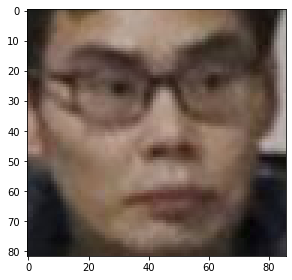

  0%|          | 1/394 [00:00<01:27,  4.51it/s]

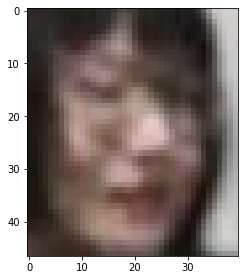

  1%|          | 2/394 [00:00<01:18,  4.97it/s]

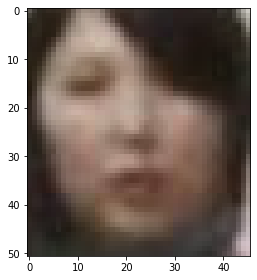

  1%|          | 3/394 [00:00<01:13,  5.36it/s]

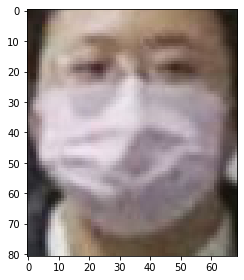

  1%|          | 4/394 [00:00<01:13,  5.31it/s]

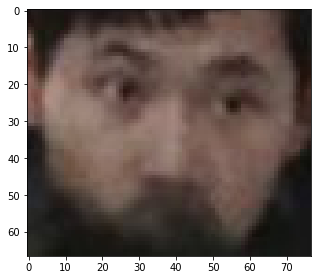

  1%|▏         | 5/394 [00:00<01:12,  5.40it/s]

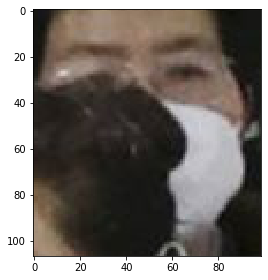

  2%|▏         | 6/394 [00:01<01:08,  5.65it/s]

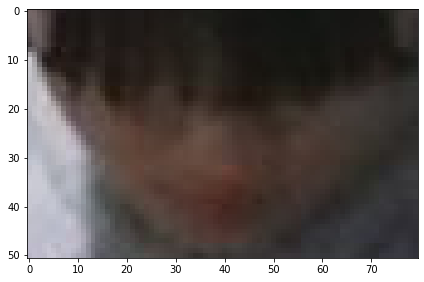

  2%|▏         | 7/394 [00:01<01:08,  5.69it/s]

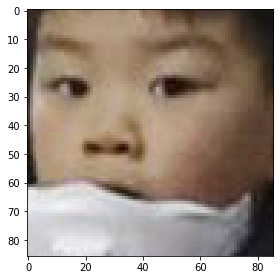

  2%|▏         | 8/394 [00:01<01:06,  5.79it/s]

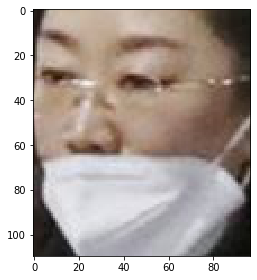

  2%|▏         | 9/394 [00:01<01:07,  5.72it/s]

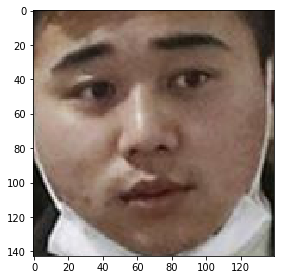

  3%|▎         | 10/394 [00:01<01:07,  5.66it/s]

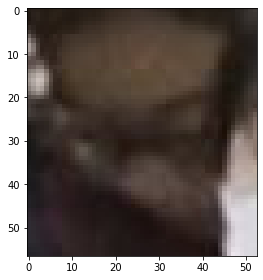

  3%|▎         | 11/394 [00:01<01:05,  5.87it/s]

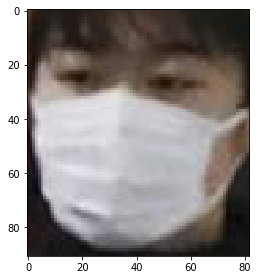

  3%|▎         | 12/394 [00:02<01:02,  6.07it/s]

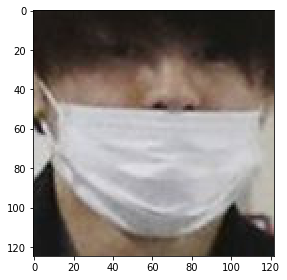

  3%|▎         | 13/394 [00:02<01:03,  6.00it/s]

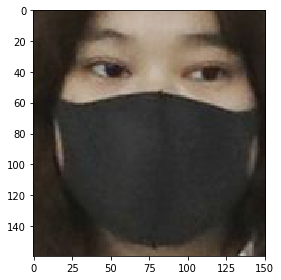

100%|██████████| 394/394 [00:11<00:00, 34.04it/s]


In [7]:
# for i in tqdm(range(len(img_num_test))):
#     filename = testData['filename'][i]
#     image_path = 'problem2-CNN/images/' + str(filename)
#     img = imread(image_path)
#     if img.shape[-1] > 3:
#         # discard alpha channel
#         img = img[:, :, :3]
#     xmin = testData['xmin'][i]
#     xmax = testData['xmax'][i]
#     ymin = testData['ymin'][i]
#     ymax = testData['ymax'][i]
#     #   切割與resize
#     partial_img_temp = img[ymin:ymax, xmin:xmax, :]
#     if i in range(14):
#         io.imshow(partial_img_temp)
#         io.show()
# #     partial_img = resize(partial_img_temp, (64, 64))
# #     partial_img = np.reshape(partial_img, (1, 3, 64, 64))
#     #   貌似normalize過惹 
# #     test_data.append(partial_img)

In [ ]:
for i in range(14):
    io.imshow(partial_img)
    io.show()


In [9]:
# plt.imshow(train_data[0])

In [10]:
print(train_data[0].shape)

(1, 3, 64, 64)


In [11]:
#train_data_temp = resize(train_data[0], (64, 64))

In [12]:
#plt.imshow(train_data_temp)

In [13]:
#np.max(train_data_temp)

In [14]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.

# N, D_in, H, D_out = 64, 1000, 100, 3
#D_in, H, D_out = 4 * 16 * 16, 100, 3


In [15]:
def evaluation(predicts, golds):
    correct = 0
    total = len(predicts)
    for predict, gold in zip(predicts, golds):
        if predict == gold:
            correct += 1
    return correct / total

In [16]:
from collections import defaultdict

def evaluation_class(predicts, golds):
    values = defaultdict(int)
    for predict, gold in zip(predicts, golds):
        if gold == 0:
            values['total_good'] += 1
            if predict == gold:
                values['correct_good'] += 1
        elif gold == 1:
            values['total_bad'] += 1
            if predict == gold:
                values['correct_bad'] += 1
        else:
            values['total_none'] += 1
            if predict == gold:
                values['correct_none'] += 1
            
            
        
    return values['correct_good'] / values['total_good'], values['correct_bad'] / values['total_bad'], values['correct_none'] / values['total_none']

In [17]:
 class Net(nn.Module):
        def __init__(self, D_in = 4 * 16 * 16, H = 100, D_out = 3):
            super(Net, self).__init__()
            self.CNN = nn.Sequential(
                    # Defining a 2D convolution layer
                Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
                BatchNorm2d(4),
                ReLU(inplace=True),
                MaxPool2d(kernel_size=2, stride=2),
                    # Defining another 2D convolution layer
                Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
                BatchNorm2d(4),
                ReLU(inplace=True),
                MaxPool2d(kernel_size=2, stride=2),

            )
            self.DNN = nn.Sequential(
                nn.Linear(D_in, H),
                nn.ReLU(),
                nn.Linear(H, D_out),
                
            )
#             self.softmax = nn.Softmax
            
        def forward(self, x):
            x = self.CNN(x)
            x = x.view(x.shape[0], -1)
            x = self.DNN(x)
#             x = self.softmax(x)
            return x

In [18]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
model = Net()
optimizer = Adam(model.parameters(), lr=0.0001)

In [19]:
#test

# train_data_temp = np.reshape(train_data_temp, (1, 3, 64, 64))
# testtest = torch.from_numpy(train_data_temp).float()
# #print(testtest)
# #testtest = Variable(testtest)
# #print(testtest)

# y_pred = CNN(testtest)
# y_pred = y_pred.view(train_data_temp.shape[0], -1)
# y_out = DNN(y_pred)
# #loss = loss_func(y_out)



In [20]:
Y_train_data = trainData['label']
Y_train_data_list = []
for i in range(len(Y_train_data)):
    if Y_train_data[i] == "good":
        Y_train_data_list.append(np.array([0]))
    elif Y_train_data[i] == "bad":
        for i in range(4):
            Y_train_data_list.append(np.array([1]))
    else:
        for i in range(20):
            Y_train_data_list.append(np.array([2]))
Y_train = np.vstack(Y_train_data_list)
        

In [21]:
# --------data unbalance-----------

# Y_train_data = trainData['label']
# Y_train_data_list = []
# for i in range(len(Y_train_data)):
#     if Y_train_data[i] == "good":
#         Y_train_data_list.append(np.array([0]))
#     elif Y_train_data[i] == "bad":
#         Y_train_data_list.append(np.array([1]))
#     else:
#         Y_train_data_list.append(np.array([2]))
# Y_train = np.vstack(Y_train_data_list)
        

In [22]:
Y_train.shape

(7238, 1)

In [23]:
Y_train = np.reshape(Y_train, (-1))


In [24]:
Y_train.shape

(7238,)

In [25]:
Y_test_data = testData['label']
Y_test_data_list = []
for i in range(len(Y_test_data)):
    if Y_test_data[i] == "good":
        Y_test_data_list.append(np.array([0]))
    elif Y_test_data[i] == "bad":
        Y_test_data_list.append(np.array([1]))
    else:
        Y_test_data_list.append(np.array([2]))
Y_test = np.vstack(Y_test_data_list)

In [26]:
Y_test = np.reshape(Y_test, (-1))

In [27]:
Y_test.shape

(394,)

In [28]:
#因為用append所以是很多np.array, 所以用vstack改成單一np.array
train_data = np.vstack(train_data)
test_data = np.vstack(test_data)

In [29]:
print(train_data.shape)

(7238, 3, 64, 64)


In [47]:
def train_epoch(model, train_data, Y_train, test_data, Y_test, batch_size = 64, epoch = 10):
    model.train()
    test_data = torch.from_numpy(test_data).float()
    Y_test = torch.from_numpy(Y_test)
    loss_append = []
    train_accur = []
    for i in range(epoch):
        permutation = np.random.permutation(train_data.shape[0])
        train_data_shuffled = train_data[permutation, :, :, :]
        Y_train_shuffled = Y_train[permutation]
        epoch_loss = 0
        batch_num = len(train_data) // batch_size
        predicts = []
        predicts_test = []
        golds = []
        
        
        for j in range(batch_num):
            model.train(mode=True)
            begin = j * batch_size
            end = min(begin + batch_size, train_data.shape[0] - 1)
            X = train_data_shuffled[begin:end, :, :, :]
#             print(X[0])
            Y = Y_train_shuffled[begin:end]
            m_batch = end - begin
            
            # converting validation images into torch format
            X = torch.from_numpy(X).float()
            Y = torch.from_numpy(Y)
            
            
            
            #X_afterCNN = CNN(X)
            #X_afterCNN = X_afterCNN.view(X.shape[0], -1)
            #X_afterDNN = DNN(X_afterCNN)
            
            X_afterDNN = model(X)
            y_hat = torch.softmax(X_afterDNN, dim=1)
            
            #------test data-------------
            model.eval()
            
            test_result_temp = model(test_data)
            test_result = torch.softmax(test_result_temp, dim=1)
            #print(X_afterDNN)
            #print(Y)
            
            loss = loss_func(y_hat, Y)
            epoch_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#             print(y_hat)
#             print(test_result)


            golds += Y.tolist()
            predicts += torch.argmax(y_hat, dim=1).tolist()
        
#         print("predict : ", predicts)

        predicts_test += torch.argmax(test_result, dim=1).tolist()
        loss_append.append(epoch_loss / train_data.shape[0])
        train_accur.append(evaluation(predicts, golds))

#         print("gold : ", golds)
#         print(predicts)
#         print(Y_train)
#         golds += np.argmax(Y_train, axis=).tolist()
        print("epoch : ", i + 1, "loss : ", epoch_loss / train_data.shape[0], "train_accur : "
              , evaluation(predicts, golds), "test_accur : ", evaluation(predicts_test, Y_test)
              , "class_train_accur : ", evaluation_class(predicts, golds)
              , "class_test_accur : ", evaluation_class(predicts_test, Y_test))
#     torch.save(model.state_dict(), "problem2-CNN/state_dict/model_state_dict")
#     torch.save(optimizer.state_dict(), "problem2-CNN/state_dict/optimizer_state_dict")
    with open("HW2_cross_entropy_loss.json", mode="w") as stream:
        json.dump(loss_append, stream)
    with open("HW2_Training_accurancy.json", mode="w") as stream:
        json.dump(train_accur, stream)
    print("predicts_test : ", predicts_test)
    print("predicts :", predicts)

In [48]:
train_epoch(model, train_data, Y_train, test_data, Y_test, batch_size = 64, epoch = 30)

epoch :  1 loss :  0.5987442371824823 train_accur :  0.9561670353982301 test_accur :  0.8984771573604061 class_train_accur :  (0.9764333450580372, 0.987012987012987, 0.8941798941798942) class_test_accur :  (0.9328621908127208, 0.9101123595505618, 0.4090909090909091)
epoch :  2 loss :  0.5978788015887895 train_accur :  0.9561670353982301 test_accur :  0.9086294416243654 class_train_accur :  (0.975378121702427, 0.9878892733564014, 0.8945594607607126) class_test_accur :  (0.950530035335689, 0.9101123595505618, 0.36363636363636365)
epoch :  3 loss :  0.5973887442224887 train_accur :  0.9564435840707964 test_accur :  0.8984771573604061 class_train_accur :  (0.9764416315049227, 0.9878840328861964, 0.894077997111218) class_test_accur :  (0.9328621908127208, 0.9101123595505618, 0.4090909090909091)
epoch :  4 loss :  0.5970853493008768 train_accur :  0.9565818584070797 test_accur :  0.9111675126903553 class_train_accur :  (0.9767932489451476, 0.9878787878787879, 0.8941289701636189) class_test_a

In [32]:
np.unique(Y_train)

array([0, 1, 2])

In [33]:
train_data[953].shape

(3, 64, 64)

In [34]:
#plt.imshow(train_data[953])

In [35]:
np.random.permutation(10)

array([5, 8, 9, 0, 6, 2, 3, 4, 1, 7])

In [36]:
a = [1, 2, 3, 4]
np.random.shuffle(a)
a

[3, 2, 4, 1]

In [37]:

for i in range(3):
    print("yo")



yo
yo
yo


In [49]:
Y_test

array([1, 1, 1, 0, 1, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0,

In [38]:
a = np.array([[2,4,6,1],[1,5,2,9]])
a


array([[2, 4, 6, 1],
       [1, 5, 2, 9]])

In [39]:
np.argmax(a, axis=1)

array([2, 3])

In [40]:
b = torch.from_numpy(a).float()
b

tensor([[2., 4., 6., 1.],
        [1., 5., 2., 9.]])

In [41]:
torch.argmax(b, dim=1)

tensor([2, 3])

In [46]:
predicts


NameError: name 'predicts' is not defined

In [42]:
trainData[trainData['filename'] == '1024x737_09186876046.jpg']

,filename,width,height,label,xmin,ymin,xmax,ymax
2443,1024x737_09186876046.jpg,1024,737,bad,150,126,282,254
2444,1024x737_09186876046.jpg,1024,737,good,58,300,192,456
2445,1024x737_09186876046.jpg,1024,737,good,233,278,346,418
2446,1024x737_09186876046.jpg,1024,737,good,376,284,515,435
2447,1024x737_09186876046.jpg,1024,737,bad,481,153,596,248
2448,1024x737_09186876046.jpg,1024,737,good,630,213,727,337
2449,1024x737_09186876046.jpg,1024,737,good,746,251,900,413
2450,1024x737_09186876046.jpg,1024,737,good,920,200,1024,354


In [43]:
trainData[trainData['filename'] == '1024x737_09186876046.jpg']["label"]

2443     bad
2444    good
2445    good
2446    good
2447     bad
2448    good
2449    good
2450    good
Name: label, dtype: object

In [44]:
# model_2 = Net(*args, **kwargs)
# model_2.load_state_dict(torch.load(PATH))
# model_2.eval()